In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.inspection import permutation_importance

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec

In [4]:
#Wir fügen zuerst ein neues Attribut hinzu, das angibt, ob die Person gestorben ist oder nicht. 
#Die Verschlüsselung erfolgt konsistent mit den anderen Attributen (2 für "nein", 1 für "ja").
#Das Todesdatum wird als Attribut verworfen. 

df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')

In [5]:
#Eine Analyse der Missing Values zeigt, dass diese vor allem in den Spalten "PREGNANT", "ICU" und "INTUBED" vorkommen.
#Das Attribut "PREGNANT" wird bei allen männlichen Patienten auf 2 gesetzt.
#Das Attribut "PATIENT_TYPE" gibt an, ob die Person hospitalisiert war oder nicht. Bei allen Patienten ohne
#Krankenhausaufenthalt kann das Attribut "ICU" auf 2 gesetzt werden, da keiner dieser Patienten folglich auf
#einer Intensivstation behandelt wurde. 
#Dieselbe Vorgehensweise wenden wir auf das Attribut "INTUBED" an. Dazu gehen wir von der Grundannahme aus, dass
#ein Anschluss an ein Beatmungsgerät im Rahmen eines Klinikaufenthaltes erfolgt. Etwaige Fälle von Heimintubation 
#vernachlässigen wir dabei. 

df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2

In [6]:
#Für die anderen fehlenden Werte können keine sinnvollen Aussagen getroffen werden. Da sie nur einen sehr kleinen
#Anteil des gesamten Datensatzes ausmachen (2.76%), verwerfen wir sie. 

for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

In [7]:
#Wir normieren das Attribut "AGE" auf das Intervall [0,1] und bilden die "2" bei den binären Attributen auf die "0" ab
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

In [8]:
#Wir fügen dem Dataframe ein neues Attribut "At_RISK" hinzu, das die ODER-Verknüpfung der drei Zielvariablen darstellt. Vorher
#casten wir den Datensatz in ein Float-Format. 
df=df.astype('float32')
df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']
df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 

In [9]:
#Wir verwerfen die beiden Attribute 'MEDICAL_UNIT' und 'USMER'

discarded_features = ['MEDICAL_UNIT', 'USMER']
df = df.drop(discarded_features, axis=1)

#Wir testen die Attribute auf Korrelation mit der Zielvariablen testen und verwerfen alle Attribute,
#die unter einem gewissen Schwellwert liegen. (->andere Feature Selection Methoden ausprobieren)

target='DIED'

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
print(not_selected_features)
df=df[selected_features]

PREGNANT   -0.021001
ASTHMA     -0.017690
TOBACCO     0.005625
Name: DIED, dtype: float64


In [10]:
#Wir teilen den Datensatz in Trainings- und Testdatensatz auf. 

test_size=0.2
train, test = train_test_split(df, test_size=test_size, shuffle=True)

train_y = train[target]
train_x = train.drop(columns=['AT_RISK','DIED'])

test_y = test[target]
test_x = test.drop(columns=['AT_RISK','DIED'])

In [19]:
#Für das KNN-Verfahren und die SVM benötigen wir einen massiv reduzierten Datensatz

train_xus, train_yus = RandomUnderSampler(sampling_strategy={0:10000,1:10000}).fit_resample(train_x, train_y)
test_xus, test_yus = RandomUnderSampler(sampling_strategy={0:10000,1:10000}).fit_resample(test_x, test_y)

#Da die Werte der Zielvariablen unbalanciert sind, wenden wir ein SMOTE-Oversampling an,
#um ein balanciertes Trainingsset zu erreichen. Die Größe des Datensatzes wird anschließend mit einem
#Random-Undersampling wieder verringert. 

"""
sm = SMOTE(sampling_strategy=0.5)
train_x, train_y = sm.fit_resample(train_x, train_y)
under = RandomUnderSampler(sampling_strategy=0.5)
train_x, train_y = under.fit_resample(train_x,train_y)
"""
train_x=train_xus
train_y=train_yus
test_x=test_xus
test_y=test_yus

In [20]:
def print_measures(clf, acc, f1, prec, rec, *args):
    if args:
        name = type(clf).__name__
        for arg in args:
            name = name + " " + arg
        
    else: 
        name = type(clf).__name__
    print(f"Klassifikator: "+name+"\n")
    print(f'Accuracy: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}'+"\n")
    
def analyze_feature_importance(train_x, train_y, classifier):
            perm_importance = permutation_importance(clf, train_x, train_y, n_repeats=10)
            sorted_idx = perm_importance.importances_mean.argsort()
            fig = plt.figure(figsize=(12, 6))
            plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
            plt.yticks(range(len(sorted_idx)), np.array(test_x.columns)[sorted_idx])
            plt.title('Permutation Importance') 

def apply_classifier(train_x, train_y, classifier, verbose=True, *args):
    classifier.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    acc, f1, prec, rec = get_scores(test_y, y_pred)
    if verbose: 
        print_measures(clf, acc, f1, prec, rec,*args)
    return acc, f1, prec, rec

In [21]:
#Wir wenden zunächst drei verschiedene Varianten eines Naive-Bayes-Klassifikators an: 

for clf in [GaussianNB(),MultinomialNB(),BernoulliNB()]:
    apply_classifier(train_x, train_y, clf)

Klassifikator: GaussianNB

Accuracy: 0.85425
F1: 0.8479949940032331
Precision: 0.8860193963168792
Recall: 0.8131

Klassifikator: MultinomialNB

Accuracy: 0.86065
F1: 0.859886380775225
Precision: 0.8646244060256799
Recall: 0.8552

Klassifikator: BernoulliNB

Accuracy: 0.8542
F1: 0.8543456543456543
Precision: 0.8534930139720559
Recall: 0.8552



In [22]:
#Danach wenden wir die logistische Regression an:

clf = LogisticRegression(max_iter=500)
apply_classifier(train_x, train_y, clf);


Klassifikator: LogisticRegression

Accuracy: 0.9048
F1: 0.9060217176702863
Precision: 0.894541910331384
Recall: 0.9178



In [23]:
#Wir wenden Support Vector Maschinen mit drei verschiedenen Kerneltypen an:
f1_measures = []

for kernel in ["linear", "poly", "rbf"]:
    clf = SVC(kernel=kernel, degree=8, class_weight='balanced')
    f1 = apply_classifier(train_xus, train_yus, clf, kernel)[1]
    f1_measures.append(f1)
    
#plt.bar(["linear", "poly", "rbf"], f1_measures, color=['blue', 'orange', 'green', 'red'], width=.6)
#plt.title('SVM kernels comparison')
#plt.xlabel('kernels')
#plt.ylabel('F-measure')
#plt.show()

Klassifikator: SVC

Accuracy: 0.8876
F1: 0.8903628560280921
Precision: 0.869002284843869
Recall: 0.9128

Klassifikator: SVC

Accuracy: 0.87495
F1: 0.8740621380734176
Precision: 0.88031240490922
Recall: 0.8679

Klassifikator: SVC

Accuracy: 0.90295
F1: 0.9076286108599438
Precision: 0.8658857713611187
Recall: 0.9536



In [24]:
#Als nächstes probieren wir KNN aus:
ks = [5,7,9]

accs = []
f1s = []
precs = []
recs = []

for k in ks:
    clf = KNeighborsClassifier(n_neighbors=k)
    # Scale the features using StandardScaler
    # scaler = StandardScaler()
    # test_x_std = scaler.fit_transform(validation_x)
    # X_test = scaler.transform(X_test)
    acc, f1, prec, rec = apply_classifier(train_xus, train_yus, clf, True, str(k))
    accs.append(acc)
    f1s.append(f1)
    precs.append(prec)
    recs.append(rec)

#plt.title('K-NN Comparison')
#plt.errorbar(ks, accs, label="acc")
#plt.errorbar(ks, f1s, label="f1")
#plt.errorbar(ks, precs, label="prec")
#plt.errorbar(ks, recs, label="rec")
#plt.legend(loc ='lower right')
#plt.xlabel('k')
#plt.show()

Klassifikator: KNeighborsClassifier 5

Accuracy: 0.89675
F1: 0.8977672161988217
Precision: 0.8890087263457201
Recall: 0.9067

Klassifikator: KNeighborsClassifier 7

Accuracy: 0.90295
F1: 0.9046987774340846
Precision: 0.888685251278094
Recall: 0.9213

Klassifikator: KNeighborsClassifier 9

Accuracy: 0.90425
F1: 0.9061872336256307
Precision: 0.8882166522615961
Recall: 0.9249



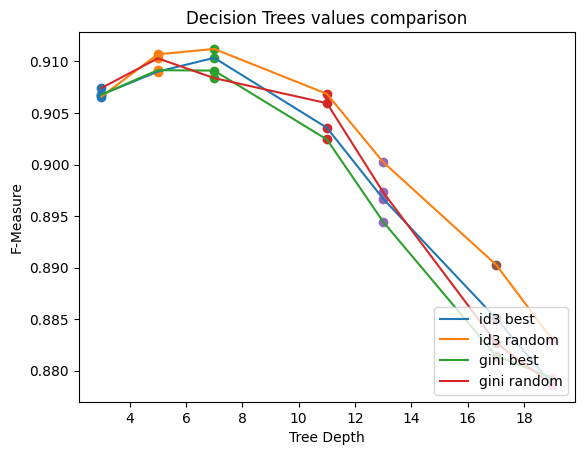

In [25]:
heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [3, 5, 7, 11, 13, 17, 19]
dt_fmeasures = {}
dt_best_result = 0
dt_best = None

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:     
        clf = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        acc, f1, prec, rec = apply_classifier(train_x, train_y, clf, False, str(d), heuristic, splitter)
        dt_fmeasures[d][i] = f1
        i=i+1

        if f1 > dt_best_result:
            dt_best_result = f1
            dt_best = clf

            
l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])

plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')
plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()



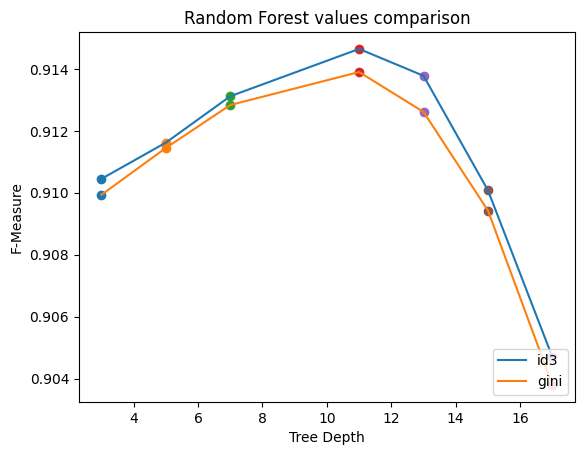

In [26]:
heuristics = ["entropy", "gini"]
max_depth = [3, 5, 7, 11, 13, 15, 17]
rf_fmeasures = {}
rf_best_result = 0

for j in range(5):
    for d in max_depth:
        rf_fmeasures[d] = np.zeros(len(heuristics))
        for (i, heuristic) in enumerate(heuristics):
            clf = RandomForestClassifier(n_estimators=100, criterion=heuristic, max_depth=d, class_weight='balanced')
            acc, f1, prec, rec = apply_classifier(train_x, train_y, clf, False, str(d), heuristic)
            rf_fmeasures[d][i] = f1
            
            if rf_fmeasures[d][i] > rf_best_result:
                rf_best_result = rf_fmeasures[d][i]
                rf_best_model = clf   
     


l1, l2 = [], []
for k in rf_fmeasures.keys():
    fmeasures = rf_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(rf_fmeasures[k][0])
    l2.append(rf_fmeasures[k][1])


plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.show()

Best Validation Loss: 0.2367
Best Validation Accuracy: 0.9104
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
Klassifikator: Sequential

Accuracy: 0.9104
F1: 0.9133797370456304
Precision: 0.8839820359281437
Recall: 0.9448



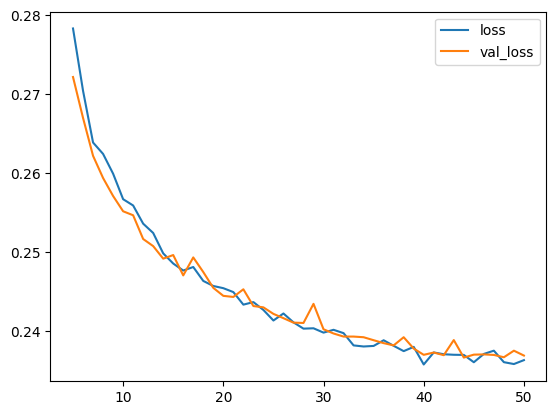

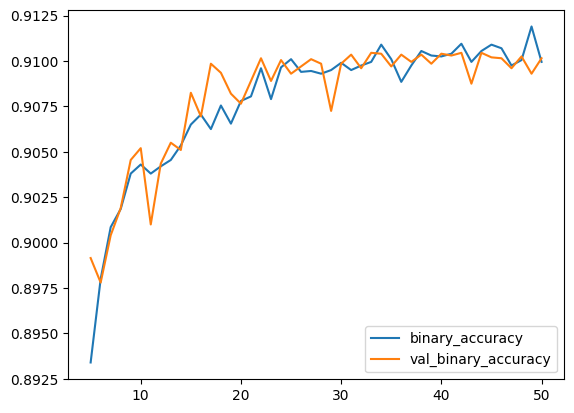

In [75]:
model = keras.Sequential([
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.01),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
#model.optimizer.learning_rate.assign(0.0001)
    
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=128, epochs=1000, 
                    callbacks=[early_stopping], verbose=0)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),
                  history_df['val_binary_accuracy'].max()))
    
y_pred = (model.predict(test_x) > 0.5).astype("int32")
acc, f1, prec, rec = get_scores(test_y, y_pred)
print_measures(model, acc, f1, prec, rec)